In [1]:
# Locations
ROOT = "C:\\OneDrive - Netherlands eScience Center\\Project_Wageningen_iOMEGA"
PATH_MS_DATA = ROOT + "\\Data\\GNPS_all\\"
PATH_SAVE_MODEL = ROOT + "\\Spec2Vec\\models_trained\\"
PATH_COMPUTED = ROOT + "\\Spec2Vec\\computed_results\\"
PATH_SAVE_DATA = ROOT + "\\Spec2Vec\\data\\"
PATH_SPEC2VEC = ROOT + "\\Spec2Vec\\code\\"

In [2]:
import numpy as np
import sys
sys.path.insert(0, PATH_SPEC2VEC)

import helper_functions as functions
import MS_functions

## Import uniqueInchikey subset (positive ionization mode)

# 1. Import and filter MS-MS data from MGF file (positive ionization mode)

### Loading MGF file
In the following the MGF file containing all spectra and metadata will be loaded. 
The MGF file was generated from all publich gnps libraries (state: 26 July 2019). Spectra annotations were checked, cleaned, and extended where possible following a procedure described in another notebook: https://github.com/iomega/Spec2Vec/blob/master/notebooks/Spec2Vec_01_MGF_from_gnps_library_search.ipynb  

### Spectra filtering
**1. Discard spectra with too few peaks.**  
Spectra with less than "min_peaks" peaks will be ignored. Here this is set to min_peaks = 10.  

**2. Filter out noise.**  
Further filtering is done to reduce the level of noise in the spectra. 
Here this is simply done by a relative intensity threshols. All peaks with intensities < maximum peak intensity will be discarded. 

Past alternative:
For this we calculate a threshold (or minimum peak intensity) for every spectrum. Where possible (most cases), this threshold is calculated by doing an exponential fit to the peak intensity histogram ("exp_intensity_filter"). If that fails we take the mean intensity of all peaks but the highest as a threshold.  

**3. But keep at least min_peaks peaks.**  
The filtering step will NOT discard any of the min_peaks highest peaks (even if those happen to be below the threshold), to guarantee that every spectra will at least have min_peaks peaks.

### Creation of documents from spectra
Peaks and losses (= precursor mass - peak mass) are converted into words using a precision of "num_decimals".  
A peak with m/z = 108.3643 will hence become a string: "peak_108.36".  
A loss with m/z = 64.2257 will hence become a string: "loss_64.23".  
All words of one spectrum are collected in one list which represents the entire spectrum as a 'document'.

In [4]:
file_json = PATH_MS_DATA + "uniqueInchikey_positive_minpeaks_10_2dec_minperc05_191109.json"
file_mgf = ROOT + "\\Data\\GNPS_all\\" + "allGNPS_positive_uniqueInchikey_191107.mgf"

spectra, spectra_dict, MS_documents, MS_documents_intensity, spectra_metadata = MS_functions.load_MGF_data(file_mgf = file_mgf,
                                                           file_json = file_json,
                                                           num_decimals = 2,
                                                           min_frag = 0.0, max_frag = 1000.0,
                                                           min_loss = 5.0, max_loss = 500.0,
                                                           min_intensity_perc = 0.5,
                                                           exp_intensity_filter = None, #0.2,
                                                           min_keep_peaks_0 = 200, #10,
                                                           min_keep_peaks_per_mz = 0, #20/200,
                                                           min_peaks = 10,
                                                           max_peaks = None,
                                                           peak_loss_words = ['peak_', 'loss_'])

Spectra json file found and loaded.


In [5]:
print("Number of imported spectra:", len(spectra))

Number of imported spectra: 10998


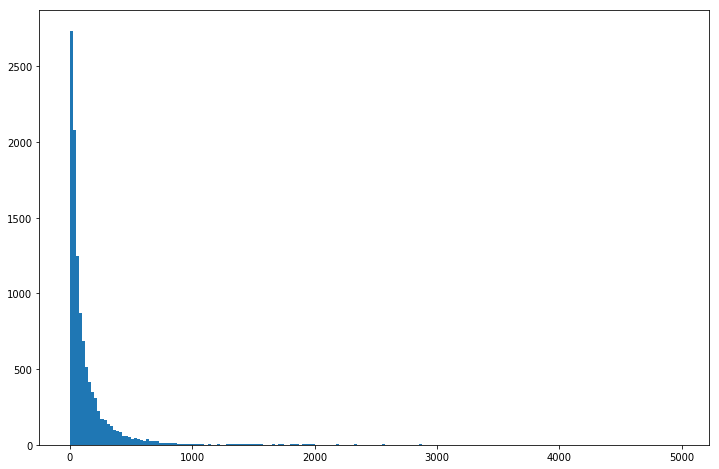

In [5]:
num_peaks = []
for spec in spectra:
    num_peaks.append(spec.n_peaks)
    
from matplotlib import pyplot as plt
plt.figure(figsize=(12,8))
a = plt.hist(num_peaks, np.arange(0,5000,25))

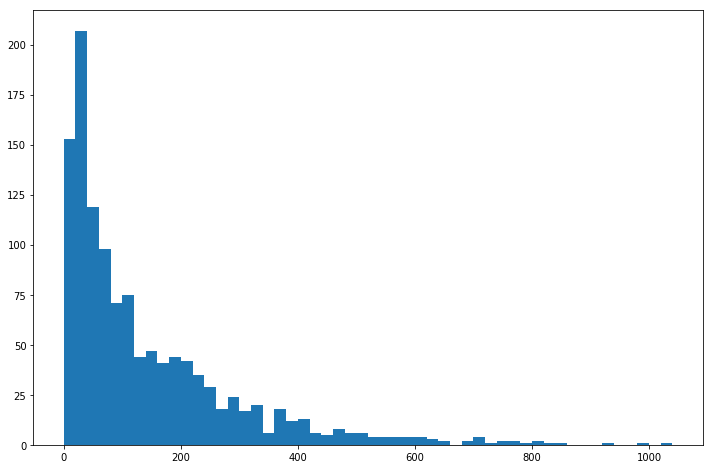

In [6]:
pepmasses = []
for spec in spectra:
    pepmasses.append(spec.precursor_mz)
    
plt.figure(figsize=(12,8))
a = plt.hist(np.array(num_peaks)[np.where(np.array(pepmasses)> 700)], np.arange(0,1050,20))

# 2. Calculate modified cosine scores for all-vs all spectra

In [6]:
import MS_similarity_classical as MS_sim_classic

filename = PATH_COMPUTED + 'modcos_scores_uniqueInchikey_pos_191107_minperc05_tol0005.npy'
M_modcos_sim_greedy, M_modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra, 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = filename,
                  safety_points = 25)

Could not find file  C:\OneDrive - Netherlands eScience Center\Project_Wageningen_iOMEGA\Spec2Vec\computed_results\modcos_scores_uniqueInchikey_pos_191107_minperc05_tol0005.npy
Modified cosine scores will be calculated from scratch.
Calculate pairwise scores by  4 number of workers.
  Calculated MolNet for pair  1 -- 7002 . (  0.03  % done)..-- 9999 . (  0.02  % done).

KeyboardInterrupt: 

In [ ]:
# time-wise: Started 19:03 ... to 2:58 --> 8 hours

In [8]:
# show number of matched peaks:
M_modcos_matches_greedy[:10,:10]

array([[ 19.,   2.,   0.,   0.,   1.,   3.,   0.,   2.,   1.,   1.],
       [  2., 134.,  49.,   0.,   1.,   2.,  13.,  82.,  50.,  48.],
       [  0.,  49.,  88.,   0.,   1.,   0.,  12.,  54.,  39.,  22.],
       [  0.,   0.,   0.,  18.,   0.,   0.,   0.,   0.,   0.,   0.],
       [  1.,   1.,   1.,   0.,  12.,   0.,   0.,   1.,   0.,   0.],
       [  3.,   2.,   0.,   0.,   0.,  22.,   0.,   1.,   0.,   1.],
       [  0.,  13.,  12.,   0.,   0.,   0.,  24.,  14.,  12.,  10.],
       [  2.,  82.,  54.,   0.,   1.,   1.,  14., 113.,  37.,  35.],
       [  1.,  50.,  39.,   0.,   0.,   0.,  12.,  37.,  80.,  30.],
       [  1.,  48.,  22.,   0.,   0.,   1.,  10.,  35.,  30.,  57.]])

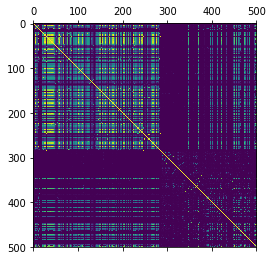

In [9]:
plt.matshow(M_modcos_sim_greedy[:500,:500])

# 3. Compare to molecular similarities based on morgan3 fingerprints
### -->  Load molecular fingerprints

In [14]:
filename = PATH_COMPUTED + 'M_mol_sim_uniqueInchikey_pos_191110_morgan3_dice.npy'
M_sim_mol = MS_sim_classic.mol_sim_matrix([], #fingerprints_morgan3_2048,
                                       [], #fingerprints_morgan3_2048,
                                       method = 'dice',
                                       filename = filename)

---- (1) Generating RDkit molecules from inchi or smiles...
No proper molecule generated for spectrum  1436
No proper molecule generated for spectrum  1441
No proper molecule generated for spectrum  2234
No proper molecule generated for spectrum  2235
No proper molecule generated for spectrum  9403
No proper molecule generated for spectrum  10810
No proper molecule generated for spectrum  11010
---- (2) Generating fingerprints from molecules...
Problem with molecule from spectrum 1436
Problem with molecule from spectrum 1441
Problem with molecule from spectrum 2234
Problem with molecule from spectrum 2235
Problem with molecule from spectrum 9403
Problem with molecule from spectrum 10810
Problem with molecule from spectrum 11010


In [17]:
# morgan3_2048_dice
plt.matshow(M_sim_mol[:100,:100])

((2048,), 10998)

In [7]:
# Find bette way to keep track of wrong fingerprints!!
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

In [27]:
# Transform molecular similarity matrix in 1D array AND remove all excluded IDs
B_morgan3 = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = B_morgan3.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
B_morgan3 = np.delete(B_morgan3.reshape(length**2), remove_diagonal)

[1435, 1440, 2232, 2233, 9384, 10791, 10991]

# 4. Compare to molecular similarities based on rdkit fingerprints
### -->  Load molecular fingerprints

In [14]:
filename = PATH_COMPUTED + 'MS_sim_mol_uniqueInchikey_rdkit2048_jaccard_191119.npy'
M_sim_mol = MS_sim_classic.mol_sim_matrix([],
                                       [],
                                       method = 'jaccard',
                                       filename = filename)

---- (1) Generating RDkit molecules from inchi or smiles...
No proper molecule generated for spectrum  1436
No proper molecule generated for spectrum  1441
No proper molecule generated for spectrum  2234
No proper molecule generated for spectrum  2235
No proper molecule generated for spectrum  9403
No proper molecule generated for spectrum  10810
No proper molecule generated for spectrum  11010
---- (2) Generating fingerprints from molecules...
Problem with molecule from spectrum 1436
Problem with molecule from spectrum 1441
Problem with molecule from spectrum 2234
Problem with molecule from spectrum 2235
Problem with molecule from spectrum 9403
Problem with molecule from spectrum 10810
Problem with molecule from spectrum 11010


In [17]:
# morgan3_2048_dice
plt.matshow(M_sim_mol[:100,:100])

((2048,), 10998)

In [7]:
# Find bette way to keep track of wrong fingerprints!!
exclude_IDs = [1435, 1440, 2232, 2233, 9384, 10791, 10991]

In [27]:
# Transform molecular similarity matrix in 1D array AND remove all excluded IDs
B_rdkit = np.delete(np.delete(M_sim_mol, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
length = B_rdkit.shape[0]
remove_diagonal = np.array([(i*length + i) for i in range(length)])
B_rdkit = np.delete(B_rdkit.reshape(length**2), remove_diagonal)

[1435, 1440, 2232, 2233, 9384, 10791, 10991]

# 5. Use molecular similarity scores for benchmarking
### Explore the influcence of min_match on mod.cosine score performance:

In [34]:
num_bins = 1000
show_top_percentile = 0.5


# Loop through different min_matches:
ref_score_cum_collection = []

length = M_sim_mol.shape[0] - len(exclude_IDs)
remove_diagonal = np.array([(i*length + i) for i in range(length)])

B = B_rdkit

N = 19
for i in range(N):
    print("Round", i, "of", N)
    
    M_sim_modcos = M_modcos_sim_greedy * (M_modcos_matches_greedy > i)
    M_sim_modcos = np.delete(np.delete(M_sim_modcos, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
    A = np.delete(M_sim_modcos.reshape(length**2), remove_diagonal)    
    
    # Calculate cumulative distributions
    Asort = np.sort(A)
    starting_point = Asort[int(A.shape[0] - A.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_As = np.where(A < starting_point)[0]
    A_select = np.delete(A, low_As)
    B_select = np.delete(B, low_As)

    length_selected = A_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = A_select
    Data[1,:] = B_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]

    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score_cum.append(np.mean(Data[1,low:]))

    ref_score_cum_collection.append(np.array(ref_score_cum))

Round 0 of 19
Round 1 of 19
Round 2 of 19
Round 3 of 19
Round 4 of 19
Round 5 of 19
Round 6 of 19
Round 7 of 19
Round 8 of 19
Round 9 of 19
Round 10 of 19
Round 11 of 19
Round 12 of 19
Round 13 of 19
Round 14 of 19
Round 15 of 19
Round 16 of 19
Round 17 of 19
Round 18 of 19


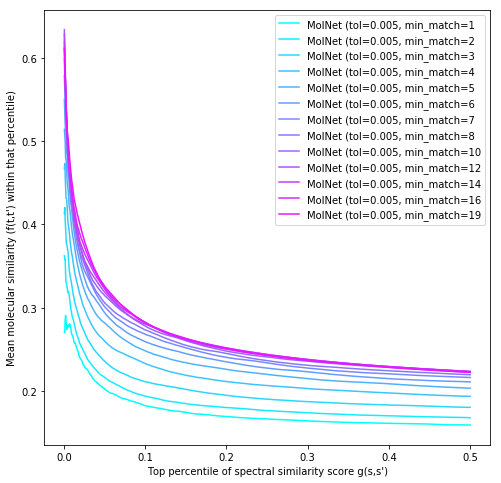

In [35]:
import matplotlib

# Compare selection:
fig, ax = plt.subplots(figsize=(8,8))
cmap = matplotlib.cm.get_cmap('cool') #('plasma') #('Spectral')

selection = [0,1,2,3,4,5,6,7,9,11,13,15,18]
N = len(selection)
for i, select in enumerate(selection):
    ref_score_cum = ref_score_cum_collection[select]
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, 
             color=cmap(i/N), #color_sequence[i], 
             label="MolNet (tol=0.005, min_match="+str(select+1))

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.savefig('Modcosine_min_match_comparison_morgan3_dice.pdf')

In [36]:
np.save('spec2vec_uniquesmiles_pos_ModCos_min_match_8.npy', ref_score_cum_collection[7])
np.save('spec2vec_uniquesmiles_pos_ModCos_min_match_10.npy', ref_score_cum_collection[9])
np.save('spec2vec_uniquesmiles_pos_ModCos_min_match_14.npy', ref_score_cum_collection[13])

### repeat for jaccard scores (morgan3 fingerprints)

In [176]:
num_bins = 1000
show_top_percentile = 0.5

ref_score_cum_collection_jaccard = []

length = M_sim_mol_jaccard.shape[0] - len(exclude_IDs)
remove_diagonal = np.array([(i*length + i) for i in range(length)])
#B = np.delete(mol_sim.reshape(length**2), remove_diagonal)

N = 19
for i in range(N):
    print("Round", i, "of", N)
    
    M_sim_modcos = modcos_sim_greedy * (modcos_matches_greedy > i)
    M_sim_modcos = np.delete(np.delete(M_sim_modcos, exclude_IDs, axis = 0), exclude_IDs, axis = 1)
    A = np.delete(M_sim_modcos.reshape(length**2), remove_diagonal)    
    
    # Calculate cumulative distributions
    Asort = np.sort(A)
    starting_point = Asort[int(A.shape[0] - A.shape[0]*show_top_percentile/100)]
    if starting_point == 0:
        print("not enough datapoints != 0 above given top-precentile")
        
    low_As = np.where(A < starting_point)[0]
    A_select = np.delete(A, low_As)
    B_select = np.delete(B_jaccard, low_As)

    length_selected = A_select.shape[0]
    Data = np.zeros((2, length_selected))
    Data[0,:] = A_select
    Data[1,:] = B_select
    Data = Data[:,np.lexsort((Data[1,:], Data[0,:]))]

    ref_score_cum = []
    
    for i in range(num_bins):
        low = int(i * length_selected/num_bins)
        high = int((i+1) * length_selected/num_bins)
        ref_score_cum.append(np.mean(Data[1,low:]))

    ref_score_cum_collection_jaccard.append(np.array(ref_score_cum))

Round 0 of 19
Round 1 of 19
Round 2 of 19
Round 3 of 19
Round 4 of 19
Round 5 of 19
Round 6 of 19
Round 7 of 19
Round 8 of 19
Round 9 of 19
Round 10 of 19
Round 11 of 19
Round 12 of 19
Round 13 of 19
Round 14 of 19
Round 15 of 19
Round 16 of 19
Round 17 of 19
Round 18 of 19


In [ ]:
import matplotlib
# Compare all:
fig, ax = plt.subplots(figsize=(8,8))
cmap = matplotlib.cm.get_cmap('cool') #('plasma') #('Spectral')

selection = [0,1,2,3,4,5,6,7,9,11,13,15,18]
N = len(selection)
for i, select in enumerate(selection):
    ref_score_cum = ref_score_cum_collection_jaccard[select]
    plt.plot((show_top_percentile/num_bins*(1+np.arange(num_bins)))[::-1], ref_score_cum, 
             color=cmap(i/N), #color_sequence[i], 
             label="MolNet (tol=0.005, min_match="+str(select+1))

plt.legend()
plt.xlabel("Top percentile of spectral similarity score g(s,s')")
plt.ylabel("Mean molecular similarity (f(t,t') within that percentile)")
plt.savefig('Modcosine_min_match_comparison_morgan3_jaccard.pdf')

In [178]:
np.save('spec2vec_uniquesmiles_pos_ModCos_jaccard_min_match_8.npy', ref_score_cum_collection_jaccard[7])
np.save('spec2vec_uniquesmiles_pos_ModCos_jaccard_min_match_10.npy', ref_score_cum_collection_jaccard[9])
np.save('spec2vec_uniquesmiles_pos_ModCos_jaccard_min_match_12.npy', ref_score_cum_collection_jaccard[11])

# Additional test of modified cosine score functions

In [4]:
import MS_similarity_classical as MS_sim_classic

### Now there is 3 ways to compute the modified cosine scores.
1. Greedy method (mostly taken from Simon)
2. Greedy method + some parts compiled using Numba.
3. More precise Hungarian algorithm + using Numba.

In [5]:
%%time
modcos_sim0, modcos_matches0 = MS_sim_classic.cosine_score_matrix(spectra[:1000], 
                  tol = 0.005, 
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy', 
                  num_workers = 4,
                  filename = None, #'testing_molent_new.npy',
                  safety_points = None)

print('\n' + 40 * '-')

Calculate pairwise scores by  4 number of workers.
  Calculated MolNet for pair  968 -- 995 . (  100.0  % done).
----------------------------------------
Wall time: 3min 16s


In [6]:
%%time
modcos_sim_greedy, modcos_matches_greedy = MS_sim_classic.cosine_score_matrix(spectra[:1000], 
                  tol = 0.005,
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='greedy-numba', 
                  num_workers = 4,
                  filename = None, #'testing_molent_new.npy',
                  safety_points = None)

print('\n' + 40 * '-')

Calculate pairwise scores by  4 number of workers.
  Calculated MolNet for pair  968 -- 995 . (  100.0  % done).lculated MolNet for pair  20 -- 209 . (  4.0  % done). 24 -- 299 . (  4.8  % done). 377 . (  10.2  % done).769 . (  11.6  % done). Calculated MolNet for pair  61 -- 890 . (  12.0  % done).71 -- 555 . (  13.8  % done).. (  15.2  % done). % done).. (  19.4  % done).-- 625 . (  23.2  % done).-- 729 . (  26.0  % done). -- 730 . (  27.2  % done). -- 909 . (  36.8  % done). % done). -- 639 . (  44.6  % done).258 -- 410 . (  45.0  % done). -- 469 . (  48.8  % done).. (  53.4  % done).-- 627 . (  54.8  % done).429 . (  59.6  % done).376 -- 875 . (  61.2  % done). -- 770 . (  61.8  % done).535 . (  62.0  % done). 435 . (  65.0  % done).. (  67.8  % done). 451 -- 925 . (  70.0  % done).. (  71.6  % done).-- 574 . (  72.4  % done). 73.2  % done).  % done). 526 -- 600 . (  77.6  % done). . (  78.0  % done). Calculated MolNet for pair  552 -- 627 . (  80.0  % done).
----------------------

In [7]:
%%time
modcos_sim, modcos_matches = MS_sim_classic.cosine_score_matrix(spectra[:1000], 
                  tol = 0.005, 
                  max_mz = 1000.0, 
                  min_intens = 0,
                  mass_shifting = True,
                  method='hungarian', 
                  num_workers = 4,
                  filename = None, #'testing_molent_new.npy',
                  safety_points = None)

print('\n' + 40 * '-')

Calculate pairwise scores by  4 number of workers.
  Calculated MolNet for pair  968 -- 995 . (  100.0  % done).9 . (  8.0  % done). 127 . (  9.2  % done). . (  12.6  % done).67 -- 277 . (  13.0  % done). -- 700 . (  14.2  % done).14.4  % done). % done).655 . (  18.4  % done).98 -- 850 . (  18.8  % done). 103 -- 355 . (  19.6  % done). -- 785 . (  22.0  % done).. (  22.6  % done). 384 . (  24.2  % done). 132 -- 777 . (  24.8  % done). 25.4  % done). 452 . (  25.6  % done). % done).. (  30.4  % done). -- 364 . (  31.0  % done).180 -- 289 . (  32.8  % done). 192 -- 527 . (  34.8  % done).-- 305 . (  35.4  % done). 36.4  % done). 527 . (  37.2  % done). -- 365 . (  37.8  % done). 260 . (  41.2  % done). . (  43.4  % done).639 . (  44.6  % done). -- 410 . (  45.0  % done).266 -- 510 . (  46.2  % done). Calculated MolNet for pair  281 -- 620 . (  48.4  % done). 285 -- 754 . (  49.0  % done). % done).298 -- 550 . (  50.8  % done).-- 680 . (  54.0  % done).350 -- 424 . (  57.8  % done). Calcu

In [8]:
mat_diff = modcos_sim_greedy - modcos_sim0
mat_diff.max(), mat_diff.min()

NameError: name 'modcos_sim_greedy' is not defined

In [9]:
mat_diff = modcos_sim_greedy - modcos_sim
mat_diff.max(), mat_diff.min()

(2.120525977034049e-14, -0.0662486241177156)

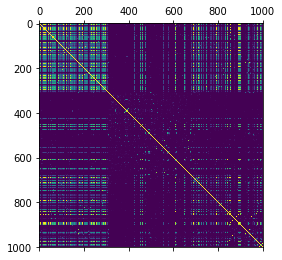

In [11]:
from matplotlib import pyplot as plt
plt.matshow(modcos_sim)

#### Check difference between greedy and hungarian computation:

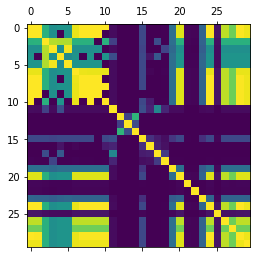

In [13]:
plt.matshow(modcos_sim0[:30,:30])

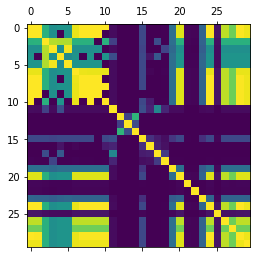

In [12]:
plt.matshow(modcos_sim_greedy[:30,:30])

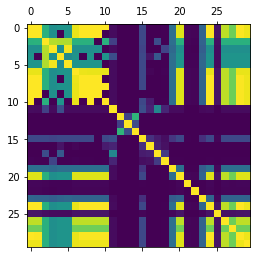

In [24]:
plt.matshow(modcos_sim[:30,:30])

In [15]:
mat_diff = modcos_sim_greedy - modcos_sim0
mat_diff.max(), mat_diff.min()

(0.9043544184552202, 0.0)

In [16]:
np.where(mat_diff > 0.9)

(array([221, 897], dtype=int64), array([897, 221], dtype=int64))

In [17]:
ID1, ID2 = 221, 897
max_mz = 1000.0
tol = 0.005
mass_shift = spectra[ID1].parent_mz - spectra[ID2].parent_mz
print(mass_shift)

spec1 = np.array(spectra[ID1].peaks, dtype=float)
spec1 = spec1[spec1[:,0] < max_mz,:]
spec2 = np.array(spectra[ID2].peaks, dtype=float)
spec2 = spec2[spec2[:,0] < max_mz,:]
#mass_shift = spectra[ID1].parent_mz - spectra[ID2].parent_mz

#MS_sim_classic.find_pairs(spec1, spec2, tol)
MS_sim_classic.cosine_score_greedy(spec1, 
                        spec2,
                        mass_shift,
                        tol, 
                        min_intens = 0,
                        use_numba = False)

217.171


(2.3282994584941852e-05,
 [(112, 5, 1.7059246489623038e-05), (115, 10, 8.686184847698088e-06)])

In [18]:
MS_sim_classic.find_pairs(spec1, spec2, tol, shift = mass_shift)

[(112, 5, 1.7059246489623038e-05), (115, 10, 8.686184847698088e-06)]

In [55]:
spec1[18:21,0], spec2[9:12,0] + mass_shift

(array([225.055695, 252.042999, 253.050598]),
 array([245.614145, 252.972726, 253.053354]))

In [19]:
#MS_sim_classic.find_pairs_numba(spec1, spec2, tol)
MS_sim_classic.cosine_score_greedy(spec1, 
                        spec2,
                        mass_shift,
                        tol, 
                        min_intens = 0,
                        use_numba = True)

(0.9043777014498052,
 [(116, 12, 1.0),
  (51, 5, 1.7059246489623038e-05),
  (101, 10, 8.686184847698088e-06)])

In [21]:
MS_sim_classic.find_pairs_numba(spec1, spec2, tol, shift = mass_shift)

[(51, 5, 1.7059246489623038e-05),
 (101, 10, 8.686184847698088e-06),
 (116, 12, 1.0)]

In [32]:
spec1[[116, 51, 101, 115],0], spec2[[12, 5, 10],0] + mass_shift

(array([341.211212, 295.205505, 323.2005  , 107.085503]),
 array([341.216212, 295.207034, 323.203578]))

In [23]:
np.abs(spec2[:,0] - spec1[51,0] + mass_shift)

array([2.7010594e+01, 2.6007386e+01, 2.4994763e+01, 9.9832510e+00,
       5.2860690e+00, 1.5290000e-03, 1.0096840e+00, 2.0172220e+00,
       1.0450190e+01, 1.8013217e+01, 2.7998073e+01, 4.3993701e+01,
       4.6010707e+01, 4.7012545e+01, 6.2005580e+01])